In [264]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import altair as alt


In [265]:
# Read the CSV file into a DataFrame
df = pd.read_csv('listings_cleaned.csv')

In [266]:
# One-hot encode the `room_type` column
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type')

In [267]:
# Select numerical features for clustering
numerical_features = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                      'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
X = df[numerical_features]

In [268]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [269]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [270]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

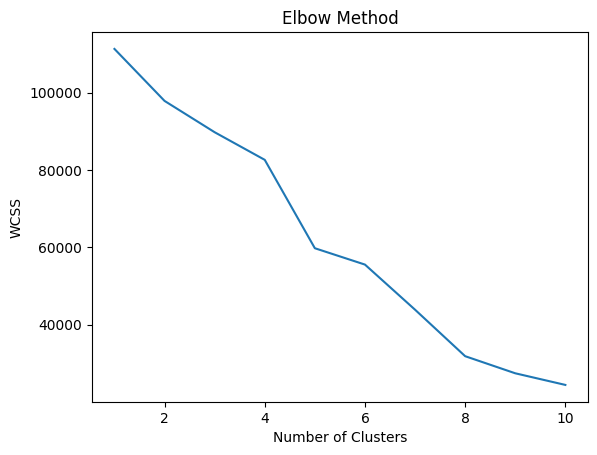

In [271]:
# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [272]:
# Apply K-means clustering with the optimal number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)

In [273]:
# Calculate the average values of property attributes for each cluster
cluster_means = df.groupby('cluster')[numerical_features].mean()

# Export cluster_means to Excel
cluster_means.to_excel("cluster_means.xlsx")

In [274]:
# Display the average values in a Markdown table
print(cluster_means.to_markdown(numalign="left", stralign="left"))

| cluster   | latitude   | longitude   | price   | minimum_nights   | number_of_reviews   | reviews_per_month   | room_type_Entire home/apt   | room_type_Hotel room   | room_type_Private room   | room_type_Shared room   |
|:----------|:-----------|:------------|:--------|:-----------------|:--------------------|:--------------------|:----------------------------|:-----------------------|:-------------------------|:------------------------|
| 0         | 37.9893    | 23.7413     | 72.7401 | 3.33739          | 27.2932             | 1.03572             | 0.993683                    | 0                      | 0.00631727               | 0                       |
| 1         | 37.9733    | 23.7254     | 107.961 | 2.16505          | 30.8628             | 1.1789              | 0.881795                    | 0.00711603             | 0.108519                 | 0.00256968              |
| 2         | 37.9759    | 23.7276     | 84.3732 | 1.69063          | 206.6               | 4.39983             

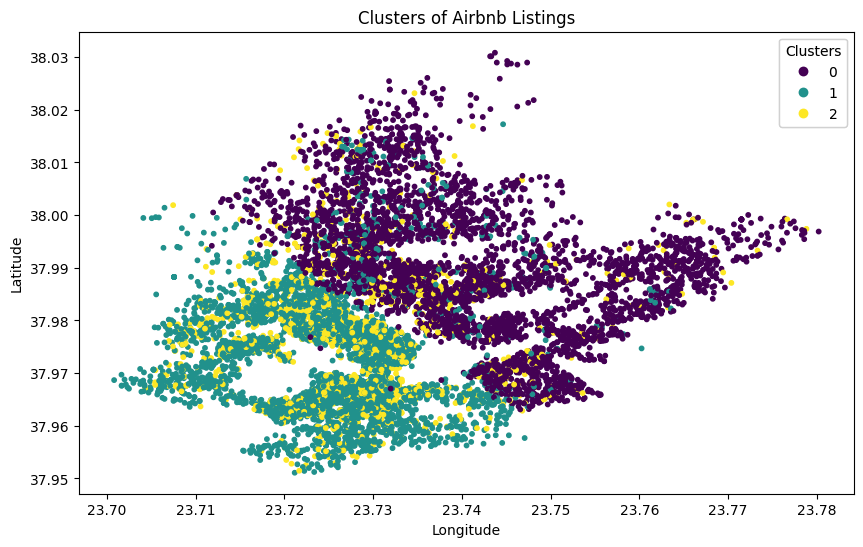

In [275]:
# Create a scatter plot of listings colored by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', s=10)
plt.title('Clusters of Airbnb Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)